In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/EC523Project"
#!ls "/content/drive/Shared with me/EC523Project"

 523_Project_Status_Update.gdoc		   lits_train.csv
 523_Project_Status_Update_Template.docx   Liver_Tumor
 Augmented_data				  'Loss Func AutoLiverCancerDetection.ipynb'
 Augmented_data_original+3transforms	  'Resize_augmented(512x512x512)'
 AutoLiverCancerDetection.ipynb		   SegmentationData
 copy_transUnet.ipynb			   transUnet.ipynb
'EC 523 Project.gdoc'			   unet_aspp_sigmoid_dice+ce.pth
'EC 523 Project Proposal.gdoc'		   unet_aspp_sigmoid_onehot.pth
 lits_df.csv				   unet_aspp_softmax_dice5+ce5.pth
 lits_probe.csv				   VolumeData
 lits_test.csv


# Training and Test Datasets

**Load the Data**

In [3]:
# Install necessary libraries. run only once
!pip install torchio==0.18.90 --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install scikit-image --quiet
!curl -s -o colormap.txt https://raw.githubusercontent.com/thenineteen/Semiology-Visualisation-Tool/master/slicer/Resources/Color/BrainAnatomyLabelsV3_0.txt
!curl -s -o slice_7t.jpg https://www.statnews.com/wp-content/uploads/2019/08/x961_unsmoothed_cropped-copy-768x553.jpg
!curl -s -o slice_histo.jpg https://upload.wikimedia.org/wikipedia/commons/6/64/Medulloepithelioma_Histology.jpg
!curl -s -o vhp.zip https://data.lhncbc.nlm.nih.gov/public/Visible-Human/Sample-Data/Six%20slices%20from%20the%20Visible%20Male.zip
!unzip -o vhp.zip > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.7/172.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 15.7 MB/s eta 0:00:00


In [4]:
import torch
import torchio as tio
from torchio import AFFINE, DATA, PATH, TYPE, STEM


In [5]:
import pickle

# Specify the file path
file_path = '/content/drive/My Drive/EC523Project/Resize_augmented(512x512x512)/dataset.pkl'
# Open the file in read-binary mode and load the dataset
with open(file_path, 'rb') as file:
    augmented_dataset = pickle.load(file)


In [ ]:
print(len(augmented_dataset))

91


<class 'torchio.data.subject.Subject'>
dict_keys(['data', 'affine', 'path', 'stem', 'type'])


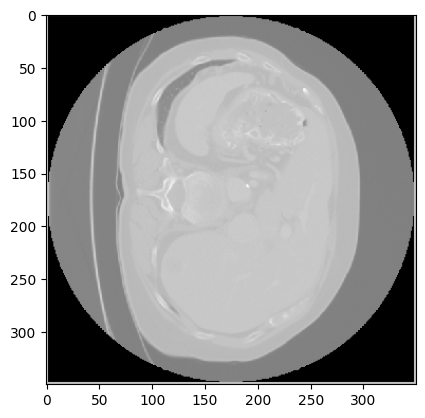

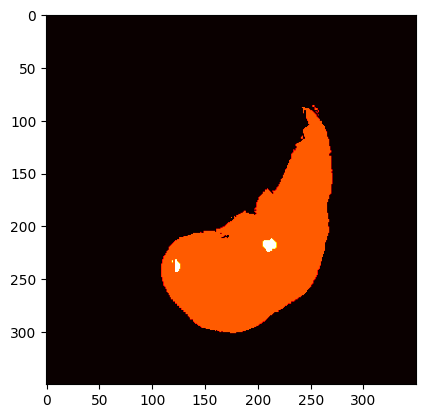

In [ ]:
import matplotlib.pyplot as plt

subject = augmented_dataset[1]
print(type(subject))

# Access the CT image tensor in the first subject
ct_image_tensor = subject['ct'][tio.DATA]
ct_mask_tensor = subject['mask'][tio.DATA]

print(subject['mask'].keys())
# print(ct_mask_tensor.shape)

# Convert the tensor to a NumPy array
ct_image_array = ct_image_tensor.numpy()
ct_mask_array = ct_mask_tensor.numpy()

# Select a 2D slice from the 3D CT image to display
ct_slice = ct_image_array[0, :, :, ct_image_array.shape[3] // 2]
ct_slice2 = ct_mask_array[0, :, :, ct_mask_array.shape[3] // 2]

# Display the slice using Matplotlib
plt.imshow(ct_slice, cmap='gray')
plt.show()
plt.imshow(ct_slice2, cmap='hot')
plt.show()


# TransUNet


In [6]:
%pip install transformers

In [7]:
import torch
import torch.nn as nn
from transformers import ViTFeatureExtractor, ViTModel

class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, padding=1)
        self.bt1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, out_channels, 3, padding=1)
        self.bt2 = nn.BatchNorm2d(out_channels)
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        else:
            self.residual_conv = None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bt1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bt2(out)
        if self.residual_conv:
            residual = self.residual_conv(residual)
        out += residual  # Add the residual connection
        out = self.relu(out)
        return out

class UNetEncoder(nn.Module):
    def __init__(self, in_channels):
        super(UNetEncoder, self).__init__()

        self.enc_conv0 = ConvBlock(in_channels, 64, 64)
        self.pool0 = nn.MaxPool2d(2, 2)
        self.enc_conv1 = ConvBlock(64, 128, 128)
        self.pool1 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        # Forward pass through U-Net encoder
        x1 = self.enc_conv0(x)
        x = self.pool0(x1)
        x2 = self.enc_conv1(x)
        x = self.pool1(x2)

        return x, [x1, x2]


In [8]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConvBlock, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        #self.conv = ConvBlock(in_channels, out_channels, out_channels)
        self.conv = ConvBlock(in_channels * 2, out_channels, out_channels)  # Modified line


    def forward(self, x, skip_connection):
        x = self.up(x)
        x = torch.cat([x, skip_connection], dim=1)
        x = self.conv(x)
        return x

#class UpConvBlock(nn.Module):
#    def __init__(self, in_channels, out_channels):
#        super(UpConvBlock, self).__init__()
#        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
#        # Adjust the in_channels for ConvBlock: it should be out_channels (from self.up) + out_channels (from skip_connection)
#        self.conv = ConvBlock(out_channels * 2, out_channels, out_channels)
#
#    def forward(self, x, skip_connection):
#        x = self.up(x)
#        x = torch.cat([x, skip_connection], dim=1)  # Concatenation changes the number of channels
#        x = self.conv(x)
#        return x


In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        attention = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(attention / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out


In [10]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerEncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attention = self.attention(x, x, x, mask)
        x = self.dropout(self.norm1(attention + x))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out


In [11]:
class Transformer(nn.Module):
    def __init__(self, embed_size, num_layers, heads, dropout, forward_expansion):
        super(Transformer, self).__init__()
        self.encoder_layers = nn.ModuleList(
            [
                TransformerEncoderLayer(embed_size, heads, dropout, forward_expansion)
                for _ in range(num_layers)
            ]
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        out = self.dropout(x)
        for layer in self.encoder_layers:
            out = layer(out, mask)

        return out


In [ ]:
#class TransUNet(nn.Module):
#    def __init__(self, num_classes, in_channels=3, embed_size=128, transformer_heads=8, transformer_layers=6, transformer_dropout=0.1, transformer_forward_expansion=4):
#        super(TransUNet, self).__init__()
#
#        self.unet_encoder = UNetEncoder(in_channels)
#        self.transformer = Transformer(embed_size, transformer_layers, transformer_heads, transformer_dropout, transformer_forward_expansion)
#
#        self.upconv1 = UpConvBlock(embed_size + 128, 128)
#        self.upconv2 = UpConvBlock(128, 64)
#        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)
#
#    def forward(self, x):
#        batch_size, channels, depth, height, width = x.shape
#        slice_outputs = []
#
#        for d in range(depth):
#            slice_2d = x[:, :, d, :, :]  # Extract 2D slice
#            encoder_output, skip_connections = self.unet_encoder(slice_2d)
#
#            n, c, h, w = encoder_output.shape
#            transformer_input = encoder_output.permute(0, 2, 3, 1).view(n, h * w, c)
#            transformer_output = self.transformer(transformer_input, None).view(n, h, w, c).permute(0, 3, 1, 2)
#
#            decoder_output = self.upconv1(transformer_output, skip_connections[-1])
#            decoder_output = self.upconv2(decoder_output, skip_connections[-2])
#
#            slice_map = self.final_conv(decoder_output)
#            slice_outputs.append(slice_map)
#
#        # Stack the outputs along the depth dimension to reconstruct the 3D volume
#        final_output = torch.stack(slice_outputs, dim=2)
#
#        return final_output


In [12]:
import torch.utils.checkpoint as checkpoint

class TransUNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, embed_size=128, transformer_heads=8, transformer_layers=1, transformer_dropout=0.1, transformer_forward_expansion=4):
        super(TransUNet, self).__init__()

        self.unet_encoder = UNetEncoder(in_channels)
        self.transformer = Transformer(embed_size, transformer_layers, transformer_heads, transformer_dropout, transformer_forward_expansion)

        #self.upconv1 = UpConvBlock(embed_size + 128, 128)
        self.upconv1 = UpConvBlock(embed_size, 128)
        self.upconv2 = UpConvBlock(128, 64)
        self.final_conv = nn.Conv2d(128, num_classes, kernel_size=1)

    def forward(self, x):
        batch_size, channels, depth, height, width = x.shape
        slice_outputs = []

        for d in range(depth):
            slice_2d = x[:, :, d, :, :]  # Extract 2D slice
            #print(f"Shape of slice {d}: {slice_2d.shape}")  # Print shape of each slice

            # Apply checkpoint to U-Net encoder
            encoder_output, skip_connections = checkpoint.checkpoint(self.encode, slice_2d)
            #print(f"Encoder output shape: {encoder_output.shape}")  # Print encoder output shape
            #print(f"Skip connections shapes: {[sc.shape for sc in skip_connections]}")  # Print shapes of skip connections

            n, c, h, w = encoder_output.shape
            transformer_input = encoder_output.permute(0, 2, 3, 1).view(n, h * w, c)
            #print(f"Transformer input shape: {transformer_input.shape}")  # Print transformer input shape

            # Apply checkpoint to Transformer
            transformer_output = checkpoint.checkpoint(self.transformer, transformer_input, None)
            transformer_output = transformer_output.view(n, h, w, c).permute(0, 3, 1, 2)

            # Upsample transformer output
            upsampled_output = self.upconv1.up(transformer_output)

            # Resize upsampled output to match the spatial dimensions of the skip connection
            upsampled_output_resized = F.interpolate(upsampled_output, size=skip_connections[-1].shape[2:], mode='bilinear', align_corners=False)

            # Concatenate upsampled output with the skip connection
            concatenated_output = torch.cat([upsampled_output_resized, skip_connections[-1]], dim=1)

            # Pass the concatenated output to the convolution part of upconv1
            decoder_output = self.upconv1.conv(concatenated_output)


            slice_map = self.final_conv(decoder_output)
            slice_outputs.append(slice_map)
            #print(f"Slice map shape: {slice_map.shape}")  # Print shape of each slice map

        # Stack the outputs along the depth dimension to reconstruct the 3D volume
        final_output = torch.stack(slice_outputs, dim=2)
        #print(f"Final output shape: {final_output.shape}")  # Print final output shape

        return final_output

    def encode(self, x):
        # This is the part of the forward pass that includes the U-Net encoder
        return self.unet_encoder(x)

# Loss

In [13]:
!pip install torch torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 5.5 MB/s eta 0:00:00


In [15]:
#dice loss definition
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module): #just set this as the criterion, like criterion = DiceLoss()
  def __init__(self):
    super(DiceLoss, self).__init__()

  def forward(self, input, target):
    smooth=1e-5 #this is just to avoid divide by 0
    input_flat = input.view(-1) #flatten input
    target_flat = target.view(-1) #flatten true labels
    intersection = (input_flat*target_flat).sum()
    return 1 - ((2.0*intersection+smooth)/(input_flat.sum()+target_flat.sum()+smooth))
class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_weight = dice_weight

    def forward(self, input, target):
        dice = self.dice_loss(input, target)
        ce_input = torch.argmax(torch.softmax(input, dim=1),dim=1)
        print(ce_input.shape)
        ce = self.ce_loss(ce_input, target.squeeze(1).long())
        combined = (self.dice_weight * dice) + ((1 - self.dice_weight) * ce)
        return combined

# Training and Testing

In [17]:
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, subjects_list):
#         self.subjects_list = subjects_list

#     def __len__(self):
#         return len(self.subjects_list)

#     def __getitem__(self, idx):
#         subject = self.subjects_list[idx]

#         image_tensor = subject['ct'][tio.DATA]
#         label_tensor = subject['mask'][tio.DATA]

#         return image_tensor, label_tensor

# dataset = CustomDataset(augmented_dataset)
loader = torch.utils.data.DataLoader(augmented_dataset, batch_size=1, shuffle=True)

In [18]:
#training and testing functions
import torchmetrics
from torchmetrics.functional.detection import intersection_over_union
import torch.optim as optim

def train_model(model, train_loader, num_epochs, optimizer, criterion, device):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_iou = 0.0
        for batch, subjects in enumerate(train_loader):
            # print(subjects['ct'])
            inputs = subjects['ct'][tio.DATA].to(device).to(dtype=torch.float)
            labels = subjects['mask'][tio.DATA].to(device).to(dtype=torch.float)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                # Assuming outputs and labels are properly formatted for IoU calculation
                iou_val = intersection_over_union(outputs, labels)
                total_iou += iou_val.item()

            total_loss += loss.item()
            if batch % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch+1}/{len(train_loader)}], Loss: {loss.item():.4f}, IoU: {iou_val.item():.4f}')

        average_loss = total_loss / len(train_loader)
        average_iou = total_iou / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}, Average IoU: {average_iou:.4f}')




def test_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for batch, subjects in enumerate(val_loader):
            # Extract the image and mask tensors from the Subject object
            inputs = subjects['ct'][tio.DATA].to(device)
            labels = subjects['mask'][tio.DATA].to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            iou_val = intersection_over_union(outputs, labels)

            total_loss += loss.item()
            total_iou += iou_val.item()

        average_loss = total_loss / len(val_loader)
        average_iou = total_iou / len(val_loader)
        print(f'Test Loss: {average_loss:.4f}, Test IoU: {average_iou:.4f}')



In [ ]:
from torch.cuda.amp import GradScaler, autocast

def train_model(model, train_loader, num_epochs, optimizer, criterion, device, grad_accumulation_steps=1):
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_iou = 0.0
        optimizer.zero_grad()

        for batch, subjects in enumerate(train_loader):
            inputs = subjects['ct'][tio.DATA].to(device).to(dtype=torch.float)
            labels = subjects['mask'][tio.DATA].to(device).to(dtype=torch.float)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels) / grad_accumulation_steps

            scaler.scale(loss).backward()

            if (batch + 1) % grad_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            with torch.no_grad():
                iou_val = intersection_over_union(outputs, labels)
                total_iou += iou_val.item()

            total_loss += loss.item()
            if batch % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch+1}/{len(train_loader)}], Loss: {loss.item():.4f}, IoU: {iou_val.item():.4f}')

        average_loss = total_loss / len(train_loader)
        average_iou = total_iou / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}, Average IoU: {average_iou:.4f}')


In [19]:
#train the model
input_channels = 1
num_classes = 2
model = TransUNet(num_classes=num_classes, in_channels=input_channels)
criterion = CombinedLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10

train_model(model, loader, num_epochs, optimizer, criterion, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


OutOfMemoryError: ignored

In [ ]:
#test the model
test_model(model, val_loader, criterion)